# Tutorial 10.1: Adversarial attacks

**Goal**: Learn something about adversarial attacks, and be aware of shortcomings of networks

Nice blog post: https://towardsdatascience.com/breaking-neural-networks-with-adversarial-attacks-f4290a9a45aa

In [1]:
## Standard libraries
import os
import json
import math
import time
import numpy as np 
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateLogger, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


## Pretrained Models on ImageNet

In [278]:
import os
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(pretrained=True)
pretrained_model = pretrained_model.to(device)

pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [279]:
# No resizing and center crop necessary as images are already preprocessed.
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), "Could not find the ImageNet dataset at expected path \"%s\". " % imagenet_path + \
                                     "Please make sure to have downloaded the ImageNet dataset here, or change the DATASET_PATH variable (currently set to %s)." % DATASET_PATH
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)
    
def get_label_index(lab_str):
    assert lab_str in label_names, "Label \"%s\" not found. Check the spelling of the class." % lab_str
    return label_names.index(lab_str)

In [280]:
pretrained_model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [281]:
pretrained_model.eval()
tp = 0.0
counter = 0
with torch.no_grad():
    for imgs, labels in tqdm(data_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        preds = pretrained_model(imgs)
        preds = preds.argmax(dim=-1)
        tp += (preds == labels).sum()
        counter += preds.shape[0]
print("Accuracy", tp.float()/counter)


Accuracy tensor(0.7774, device='cuda:0')


In [282]:
def show_prediction(img, label, pred, K=5):
    
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
    fig, ax = plt.subplots(1,2, figsize=(10,3))
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[1].set_yticks(np.arange(K))
    ax[1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[1].invert_yaxis()
    ax[1].set_xlabel('Accuracy')
    ax[1].set_title('Predictions')
    
    plt.show()
    plt.close()

In [283]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
    preds = torch.softmax(preds, dim=-1)

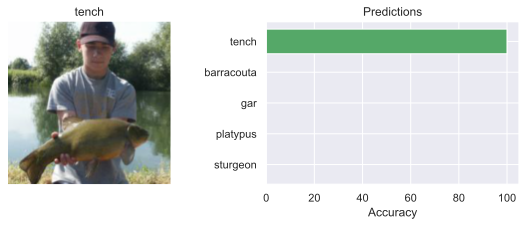

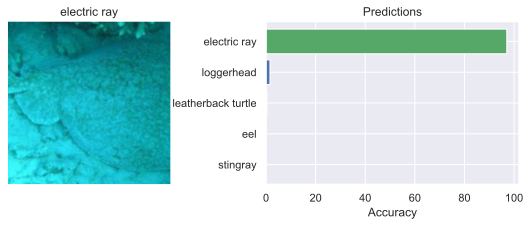

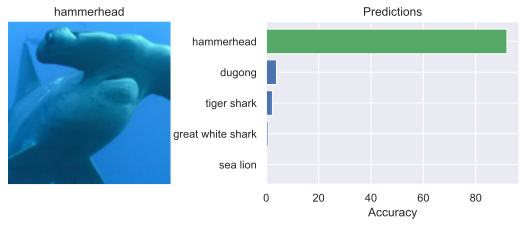

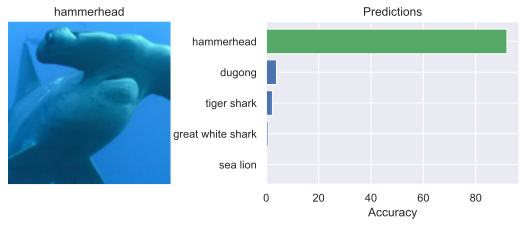

In [284]:
for i in np.random.randint(0,exmp_batch.shape[0]-1,4):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

## White-box adversarial attacks

### Fast Gradient Sign Method (FGSM)

Explaining and Harnessing Adversarial Examples (https://arxiv.org/pdf/1412.6572.pdf)

(224, 224, 1)
(8, 224, 224, 3)


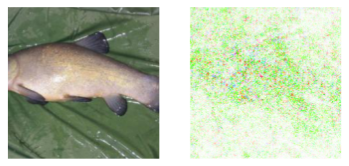

(224, 224, 1)
(8, 224, 224, 3)


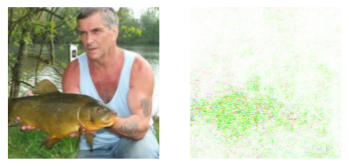

(224, 224, 1)
(8, 224, 224, 3)


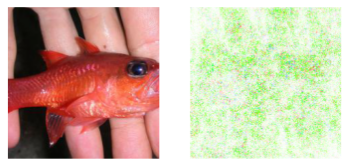

(224, 224, 1)
(8, 224, 224, 3)


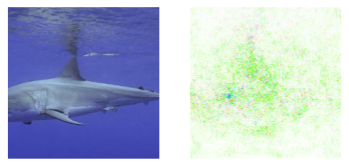

(224, 224, 1)
(8, 224, 224, 3)


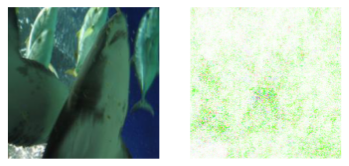

(224, 224, 1)
(8, 224, 224, 3)


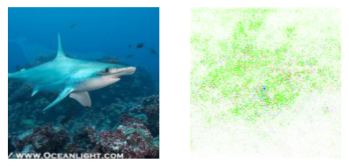

(224, 224, 1)
(8, 224, 224, 3)


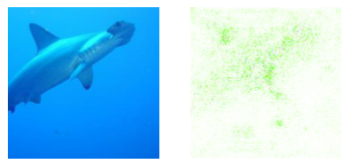

(224, 224, 1)
(8, 224, 224, 3)


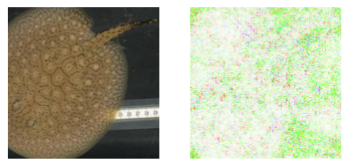

In [314]:
def visualize_attention(model, imgs, labels):
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    loss = torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    grad_intensity = inp_imgs.grad.abs()
    
    imgs = imgs.permute(0,2,3,1).cpu().numpy()
    imgs = (imgs * NORM_STD[None,None]) + NORM_MEAN[None,None]
    imgs = np.clip(imgs, a_min=0.0, a_max=1.0)
    grad_intensity = grad_intensity.permute(0,2,3,1).cpu().numpy()
    for i in range(imgs.shape[0]):
        fig, ax = plt.subplots(1,2)
        
        ax[0].imshow(imgs[i])
        ax[0].axis('off')
        
        # ax[1].imshow(imgs[i])
        alpha_channel = grad_intensity[i].max(axis=-1, keepdims=True) / grad_intensity[i].max() * 4
        alpha_channel = np.clip(alpha_channel, a_min=0.0, a_max=1.0)
        grad_intensity[i] = grad_intensity[i] / grad_intensity[i].max(axis=-1, keepdims=True)
        print(alpha_channel.shape)
        print(grad_intensity.shape)
        ax[1].imshow(np.concatenate([grad_intensity[i], alpha_channel], axis=-1))
        ax[1].axis('off')
        
        plt.show()
        plt.close()

exmp_batch, label_batch = next(iter(data_loader))
exmp_batch, label_batch = exmp_batch[:32:4], label_batch[:32:4]

visualize_attention(pretrained_model, exmp_batch, label_batch)

In [286]:
def adversarial_attack(model, imgs, labels, target_labels=None, noise_level=0.07):
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    if target_labels is None:
        loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    else:
        loss = torch.gather(preds, 1, target_labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    print(noise_grad.shape)
    fake_imgs = imgs + noise_level * noise_grad
    return fake_imgs, noise_grad

exmp_batch_2, noise_grad = adversarial_attack(pretrained_model, exmp_batch, label_batch)
print((exmp_batch[0] - exmp_batch_2[0]).abs().max())
with torch.no_grad():
    preds_2 = pretrained_model(exmp_batch_2.to(device))
    preds_2 = torch.softmax(preds_2, dim=-1)
print((preds_2[0] - preds[0]).abs().max())

torch.Size([32, 3, 224, 224])
tensor(0.0700)
tensor(0.9960, device='cuda:0')


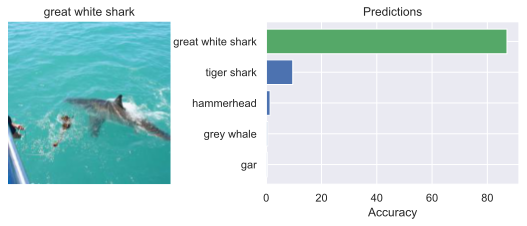

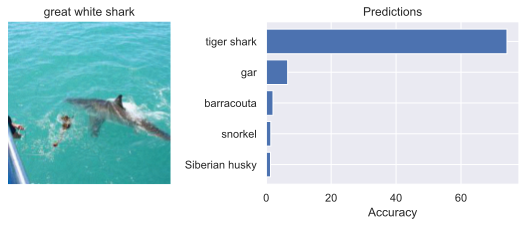

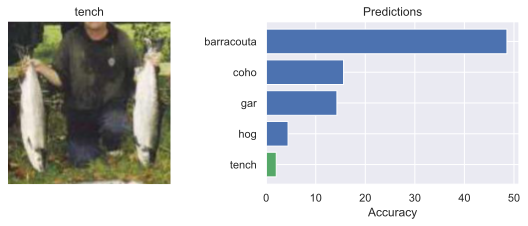

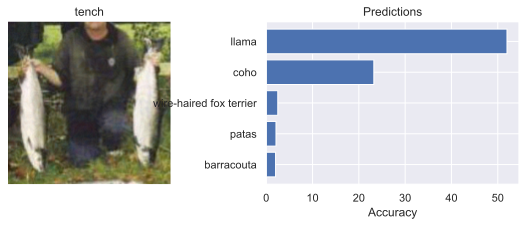

In [287]:
for i in np.random.randint(0,exmp_batch.shape[0]-1,2):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])
    show_prediction(exmp_batch_2[i], label_batch[i], preds_2[i])

In [288]:
exmp_batch_3, noise_grad = adversarial_attack(pretrained_model, exmp_batch, label_batch, target_labels=torch.ones_like(label_batch), noise_level=0.05)
print((exmp_batch[0] - exmp_batch_3[0]).abs().max())
with torch.no_grad():
    preds_3 = pretrained_model(exmp_batch_3.to(device))
    preds_3 = torch.softmax(preds_3, dim=-1)
print((preds_3[0] - preds[0]).abs().max())

torch.Size([32, 3, 224, 224])
tensor(0.0500)
tensor(0.5989, device='cuda:0')


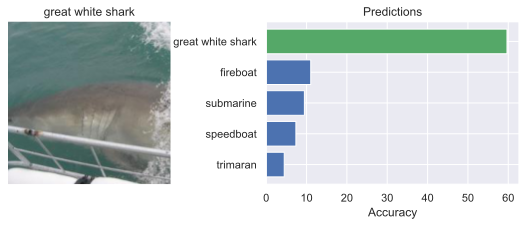

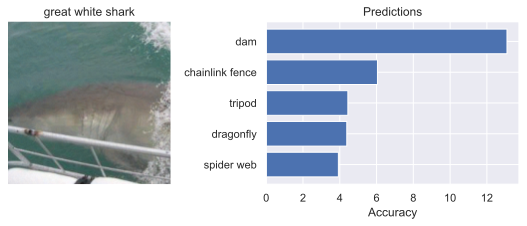

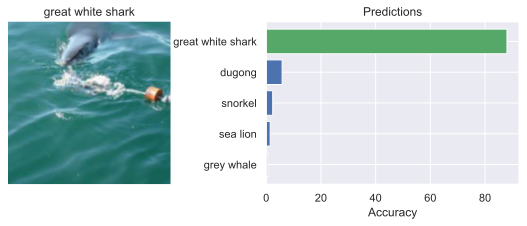

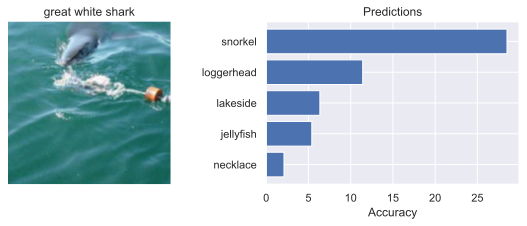

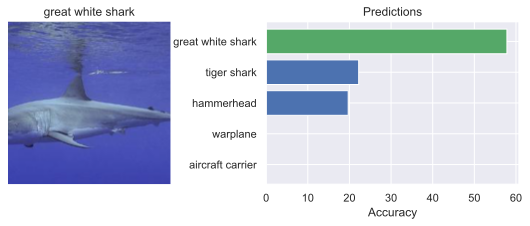

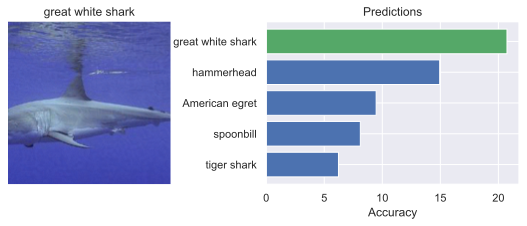

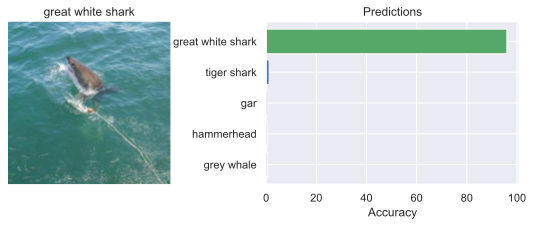

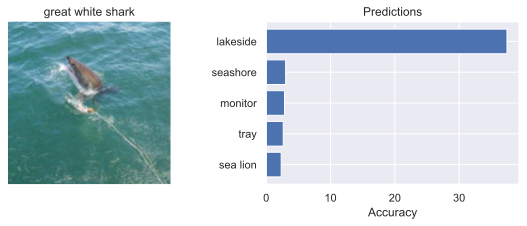

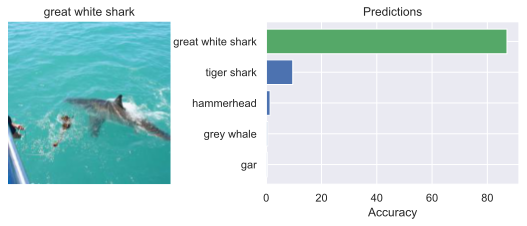

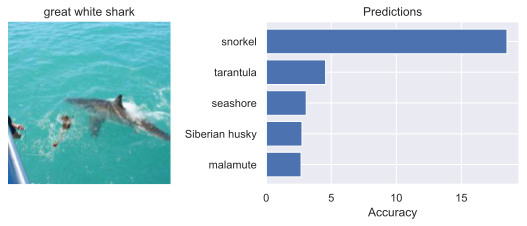

In [289]:
for i in range(10,15): # np.random.randint(0,exmp_batch.shape[0]-1,2):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])
    show_prediction(exmp_batch_3[i], label_batch[i], preds_3[i])

### Adversarial Patch

Adversarial Patch (https://arxiv.org/pdf/1712.09665.pdf)

In [292]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

def show_patch(patch, target_class):
    patch = patch.detach().cpu().permute(1, 2, 0).numpy()
    patch = (patch * NORM_STD[None,None]) + NORM_MEAN[None,None]
    patch = np.clip(patch, a_min=0.0, a_max=1.0)
    plt.imshow(patch)
    plt.title(label_names[target_class])
    plt.axis('off')
    plt.show()
    plt.close()

def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating..."):
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    print("Fool accuracy: %4.2f%% (Top-5: %4.2f%%)" % (acc*100.0, top5*100.0))
    return acc, top5

def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
        
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)
    
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description("Epoch %i, Loss: %4.2f" % (epoch, loss.item()))
    
    show_patch(patch, target_class)
    
    acc, top5 = eval_patch(model, patch, val_loader, target_class)
    
    return patch.data, {"acc": acc, "top5": top5}

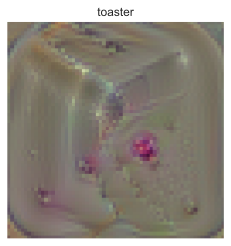


Fool accuracy: 94.70% (Top-5: 99.10%)


In [293]:
patch, results = patch_attack(pretrained_model, target_class=859, patch_size=64, num_epochs=2)

In [294]:
exmp_batch_4 = exmp_batch.clone()
exmp_batch_4 = place_patch(exmp_batch_4, patch)
with torch.no_grad():
    preds_4 = pretrained_model(exmp_batch_4.to(device))
    preds_4 = torch.softmax(preds_4, dim=-1)

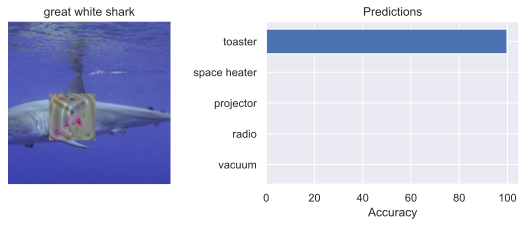

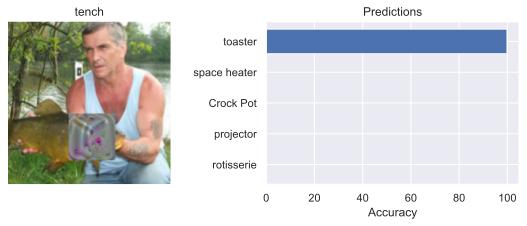

In [295]:
for i in np.random.randint(0,exmp_batch_4.shape[0]-1,2):
    show_prediction(exmp_batch_4[i], label_batch[i], preds_4[i])

In [296]:
print(label_names.index('toaster'))
sorted(label_names)

859


['Afghan hound',
 'African chameleon',
 'African crocodile',
 'African elephant',
 'African grey',
 'African hunting dog',
 'Airedale',
 'American Staffordshire terrier',
 'American alligator',
 'American black bear',
 'American chameleon',
 'American coot',
 'American egret',
 'American lobster',
 'Angora',
 'Appenzeller',
 'Arabian camel',
 'Arctic fox',
 'Australian terrier',
 'Band Aid',
 'Bedlington terrier',
 'Bernese mountain dog',
 'Blenheim spaniel',
 'Border collie',
 'Border terrier',
 'Boston bull',
 'Bouvier des Flandres',
 'Brabancon griffon',
 'Brittany spaniel',
 'CD player',
 'Cardigan',
 'Chesapeake Bay retriever',
 'Chihuahua',
 'Christmas stocking',
 'Crock Pot',
 'Dandie Dinmont',
 'Doberman',
 'Dungeness crab',
 'Dutch oven',
 'Egyptian cat',
 'English foxhound',
 'English setter',
 'English springer',
 'EntleBucher',
 'Eskimo dog',
 'European fire salamander',
 'European gallinule',
 'French bulldog',
 'French horn',
 'French loaf',
 'German shepherd',
 'German s

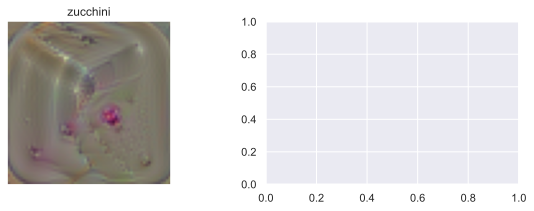

In [297]:
show_prediction(patch, label=torch.LongTensor([939]), pred=None)

## Transferibility of white-box attacks

In [300]:
another_network = torchvision.models.mobilenet_v2(pretrained=True)
another_network = another_network.to(device)

In [301]:
_ = eval_patch(another_network, patch, data_loader, target_class=get_label_index('toaster'))


Fool accuracy: 56.67% (Top-5: 78.72%)


## Protecting against adversarial attacks

## CIFAR10

Not used anymore (right now)

In [252]:
assert False, "Stopping here"

AssertionError: Stopping here

In [2]:
# Transformations applied on each image => only make them a tensor
plain_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5,),(0.5,))])
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.Pad(4, fill=128),
                                      transforms.RandomCrop(32),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,),(0.5,)),
                                      ])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=plain_transform, download=True)
pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [42000, 8000])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [42000, 8000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=plain_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


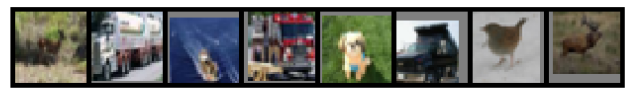

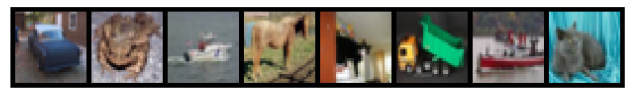

In [3]:
def show_imgs(imgs, labels=None, title=None):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 8 if labels is None else 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, normalize=True, range=(-1,1), pad_value=0.0)
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()
    
imgs, labels = next(iter(train_loader))
show_imgs(imgs[:8])    
imgs, labels = next(iter(val_loader))
show_imgs(imgs[:8])

In [4]:
class ResNetBlock(nn.Module):
    
    def __init__(self, c_in, act_fn : nn.ReLU, subsample=False):
        super().__init__()
        c_out = c_in if not subsample else 2*c_in
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_in, kernel_size=3, padding=1, stride=1 if not subsample else 2),
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out)
        )
        # Average Pool with kernel size means we only take the upper left value. Represents a identity mapping with stride
        self.downsample = nn.AvgPool2d(kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()
    
    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
            x = torch.cat([x, torch.zeros_like(x)], dim=1)
        z = z + x
        out = self.act_fn(z)
        return out

In [5]:
class ResNet(nn.Module):
    
    def __init__(self, num_classes=10, c_hidden=16, num_blocks=3, act_fn=nn.ReLU):
        super().__init__()
        self.hparams = {"num_classes": num_classes, "c_hidden": c_hidden, "num_blocks": num_blocks, "act_fn": act_fn}
        self._create_network()
        
    def _create_network(self):
        c_hidden = self.hparams["c_hidden"]
        input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(c_hidden),
            self.hparams["act_fn"]()
        )
        stack1 = nn.Sequential(*[ResNetBlock(c_in=c_hidden, 
                                                 act_fn=self.hparams["act_fn"]) 
                                     for _ in range(self.hparams["num_blocks"])])
        stack2a = ResNetBlock(c_in=c_hidden,
                                   act_fn=self.hparams["act_fn"],
                                   subsample=True)
        stack2b = nn.Sequential(*[ResNetBlock(c_in=2*c_hidden, 
                                                 act_fn=self.hparams["act_fn"]) 
                                     for _ in range(self.hparams["num_blocks"]-1)])
        stack3a = ResNetBlock(c_in=2*c_hidden,
                                   act_fn=self.hparams["act_fn"],
                                   subsample=True)
        stack3b = nn.Sequential(*[ResNetBlock(c_in=4*c_hidden, 
                                                 act_fn=self.hparams["act_fn"]) 
                                     for _ in range(self.hparams["num_blocks"]-1)])
        output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(4*c_hidden, self.hparams["num_classes"])
        )
        
        self.net = nn.Sequential(
            input_net,
            stack1,
            stack2a,
            stack2b,
            stack3a,
            stack3b,
            output_net
        )
        
    def forward(self, x):
        return self.net(x)

In [6]:
model = ResNet(num_blocks=1)

In [7]:
imgs, labels = next(iter(train_loader))
out = model(imgs)
print(out.shape)

torch.Size([256, 10])


In [8]:
class CNN(pl.LightningModule):
    
    def __init__(self, 
                 test=False,
                 **kwargs):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters() 
        # Creating encoder and decoder
        self.net = ResNet(**kwargs)
        self.loss_module = nn.CrossEntropyLoss()
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = train_set[0][0].unsqueeze(dim=0)
        
    def forward(self, x):
        preds = self.net(x)
        return preds
    
    def _run_model(self, batch):
        imgs, labels = batch # We do not need the labels
        preds = self.net(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        return loss, acc
    
    def _eval(self, batch, batch_idx, prefix=""):
        loss, acc = self._run_model(batch)
        result = pl.EvalResult(checkpoint_on=acc)
        result.log(prefix+'loss', loss)
        result.log(prefix+'acc', acc)
        return result
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-4)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode='min', 
                                                         factor=0.2, 
                                                         patience=10, 
                                                         min_lr=5e-5)
        return [optimizer], [{"scheduler": scheduler, "monitor": "checkpoint_on"}]
    
    def training_step(self, batch, batch_idx):
        loss, acc = self._run_model(batch)                             
        result = pl.TrainResult(minimize=loss)
        result.log('train_loss', loss)
        result.log('train_acc', acc)
        return result
    
    def validation_step(self, batch, batch_idx):
        return self._eval(batch, batch_idx, prefix="val_")
    
    def test_step(self, batch, batch_idx):
        return self._eval(batch, batch_idx, prefix="test_")

In [9]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "cifar10"), 
                         checkpoint_callback=ModelCheckpoint(save_weights_only=True, mode="max"),
                         gpus=1, 
                         max_epochs=140,
                         callbacks=[LearningRateLogger("epoch")])
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "cifar10.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = CNN.load_from_checkpoint(pretrained_filename)
    else:
        model = CNN(**kwargs)
        trainer.fit(model, train_loader, val_loader)
    # Test best model on validation and test set
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}
    return model, result

In [10]:
model, result = train_model()

GPU available: True, used: True
I0913 09:55:53.154482 140700657817408 distributed.py:41] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I0913 09:55:53.156012 140700657817408 distributed.py:41] TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
I0913 09:55:53.157091 140700657817408 distributed.py:41] CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | net         | ResNet           | 235 K  | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
I0913 09:55:55.279673 140700657817408 lightning.py:1449] 
  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | net         | ResNet           | 235 K  | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?  

/home/phillip/anaconda3/envs/nlp1/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..
I0913 09:55:58.061491 140700657817408 training_loop.py:1136] Saving latest checkpoint..


In [11]:
result

{'test': [{'test_loss': 1.614057183265686, 'test_acc': 0.3863281309604645}],
 'val': [{'test_loss': 1.6177482604980469, 'test_acc': 0.388916015625}]}

In [12]:
exmp_imgs, labels = next(iter(val_loader))
exmp_imgs, labels = exmp_imgs[:8], labels[:8]

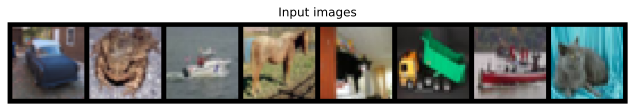

True class: automobile (1). Prediction - max: dog (5)
All predictions: [(0) 5.97% (1) 1.83% (2) 22.85% (3) 20.39% (4) 10.51% (5) 23.50% (6) 5.06% (7) 6.61% (8) 2.29% (9) 1.00%]

True class: frog (6). Prediction - max: frog (6)
All predictions: [(0) 0.40% (1) 0.60% (2) 9.05% (3) 18.79% (4) 17.52% (5) 20.64% (6) 21.99% (7) 10.68% (8) 0.17% (9) 0.17%]

True class: ship (8). Prediction - max: ship (8)
All predictions: [(0) 28.62% (1) 1.39% (2) 13.97% (3) 2.71% (4) 13.70% (5) 2.51% (6) 2.60% (7) 1.77% (8) 30.02% (9) 2.70%]

True class: horse (7). Prediction - max: deer (4)
All predictions: [(0) 0.44% (1) 0.39% (2) 13.61% (3) 9.48% (4) 28.32% (5) 9.81% (6) 27.68% (7) 9.99% (8) 0.15% (9) 0.12%]

True class: cat (3). Prediction - max: dog (5)
All predictions: [(0) 1.04% (1) 0.53% (2) 11.18% (3) 20.59% (4) 8.76% (5) 41.68% (6) 6.28% (7) 9.33% (8) 0.42% (9) 0.18%]

True class: truck (9). Prediction - max: frog (6)
All predictions: [(0) 0.33% (1) 0.41% (2) 7.38% (3) 3.37% (4) 28.95% (5) 2.48% (6)

In [13]:
def evaluate_predictions(model, exmp_imgs, labels):
    model.eval()
    with torch.no_grad():
        preds = model.net(exmp_imgs.to(device))
        preds = torch.softmax(preds, dim=-1)
    preds = preds.cpu().numpy()
    max_pred = np.argmax(preds, axis=-1)
    show_imgs(exmp_imgs, title="Input images")
    for i in range(preds.shape[0]):
        print("True class: %s (%i). Prediction - max: %s (%i)\nAll predictions: [%s]" % (label_names[labels[i]], 
                                                                                         labels[i], 
                                                                                         label_names[max_pred[i]],
                                                                                         max_pred[i],
                                                                                         " ".join(["(%i) %4.2f%%" % (j, preds[i,j]*100.0) for j in range(preds.shape[1])])))
        print()
        
evaluate_predictions(model, exmp_imgs, labels)

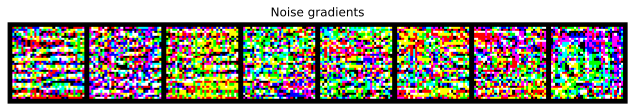

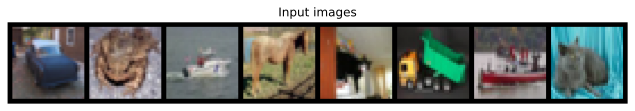

True class: automobile (1). Prediction - max: bird (2)
All predictions: [(0) 5.35% (1) 1.25% (2) 25.36% (3) 20.08% (4) 10.31% (5) 24.68% (6) 4.57% (7) 6.10% (8) 1.68% (9) 0.61%]

True class: frog (6). Prediction - max: dog (5)
All predictions: [(0) 0.46% (1) 0.60% (2) 10.36% (3) 21.74% (4) 15.04% (5) 26.05% (6) 15.92% (7) 9.50% (8) 0.19% (9) 0.15%]

True class: ship (8). Prediction - max: airplane (0)
All predictions: [(0) 24.92% (1) 1.25% (2) 21.87% (3) 3.64% (4) 19.25% (5) 3.84% (6) 3.47% (7) 2.64% (8) 17.03% (9) 2.09%]

True class: horse (7). Prediction - max: deer (4)
All predictions: [(0) 0.43% (1) 0.35% (2) 14.71% (3) 9.53% (4) 29.00% (5) 9.72% (6) 27.73% (7) 8.28% (8) 0.15% (9) 0.11%]

True class: cat (3). Prediction - max: dog (5)
All predictions: [(0) 1.13% (1) 0.60% (2) 11.26% (3) 18.65% (4) 9.68% (5) 39.61% (6) 6.90% (7) 11.47% (8) 0.46% (9) 0.24%]

True class: truck (9). Prediction - max: frog (6)
All predictions: [(0) 0.24% (1) 0.26% (2) 7.03% (3) 3.44% (4) 28.90% (5) 2.62

In [15]:
adv_imgs, noise_grad = adversarial_attack(model, exmp_imgs, labels)
show_imgs(noise_grad, title="Noise gradients")
evaluate_predictions(model, adv_imgs, labels)